This is an extract of the code I have used for my thesis. Here I present the results of some trading strategies 
using a portfolio composed of five different assets on 20 years of data (with a total of approximately 32,000 observations).

The visual results are presented at the end of the script.

In [1]:
import pandas as pd
import numpy as np
import math
import numpy_financial as npf
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

from muarch import MUArch, UArch
from muarch.datasets import load_etf
from copulae import TCopula

import matplotlib as mpl 
import matplotlib.pyplot as plt  
import matplotlib.ticker as plticker
import pylab
import datetime
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter

plt.style.use('seaborn')  
mpl.rcParams['font.family'] = 'serif'  
%matplotlib inline 


import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [181]:
df = pd.read_excel(r'C:\Users\samuv\OneDrive\Desktop\Tesi\Shorter window 500\df.xlsx', index_col=0, parse_dates=True)

In [183]:
df.describe()

,DAX,Euro_Stoxx_50,S&P500,Gold,Oil,10Y Features,Multiasset_returns
count,5309.000000,5309.000000,5309.000000,5309.000000,5309.000000,5309.000000,5309.000000
mean,0.000103,-0.000043,0.000228,0.000324,0.001443,0.000164,0.000345
std,0.014793,0.014602,0.012414,0.010905,0.045440,0.000193,0.011762
min,-0.130549,-0.132405,-0.127652,-0.095962,-0.693147,-0.000006,-0.101111
25%,-0.006719,-0.006745,-0.004824,-0.004866,-0.012404,0.000010,-0.004486
50%,0.000717,0.000314,0.000636,0.000241,0.001110,0.000101,0.000527
75%,0.007381,0.007012,0.005886,0.005886,0.013603,0.000242,0.005397
max,0.107975,0.104376,0.109572,0.068414,0.693147,0.000693,0.115353


# Buy and Hold, Constant Mix and CPPI

Buy and Hold: we start with an allocation of 70/30

In [159]:
#empty column with Investment Value Bond
df['Value_B(B&H)'] = ""
#set first value 
df['Value_B(B&H)'].iloc[0] = 30

In [160]:
#empty column with Multiasset portfolio
df["Value_I(B&H)"] = ""
#set first value 
df['Value_I(B&H)'].iloc[0] = 70

In [161]:
#empty column Investment Value Portfolio
df["Value_P(B&H)"] = ""
df["Value_P(B&H)"].iloc[0] = df['Value_I(B&H)'].iloc[0]  + df['Value_B(B&H)'].iloc[0]

In [162]:
for i in range(1, len(df)):
    df['Value_B(B&H)'].iloc[i] = df['Value_B(B&H)'].iloc[i-1] * (1+ df['10Y Features'].iloc[i])

In [163]:
#fill column buy-and-hold strategy for initial investment in index
for i in range(1, len(df)):
    df['Value_I(B&H)'].iloc[i] = df['Value_I(B&H)'].iloc[i-1] * (1+ df['Multiasset_returns'].iloc[i])

In [164]:
#fill column with portfolio value
for i in range(0, len(df)):
    df['Value_P(B&H)'].iloc[i] = df['Value_I(B&H)'].iloc[i] + df['Value_B(B&H)'].iloc[i]

Constant Mix

In [165]:
df_CM = df[['Multiasset_returns','10Y Features']].copy()

In [166]:
#find third friday in month (expiry)
from datetime import datetime 

df_CM['Rebalance_Date'] = ''

for i in range(0,len(df),7):
    df_CM['Rebalance_Date'].iloc[i] = True

In [167]:
Weight_Bond = 0.30
Weight_Index = 0.70
Investment_amount_CM = 100

In [168]:
#empty column with Investment Value Bond before rebalancing
df_CM["Value_B(C-M)"] = ""
#set first value 
df_CM['Value_B(C-M)'].iloc[0] = Weight_Bond * Investment_amount_CM

In [169]:
#empty column with Investment Value Index before rebalancing
df_CM["Value_I(C-M)"] = ""
#set first value 
df_CM['Value_I(C-M)'].iloc[0] = Weight_Index * Investment_amount_CM

In [170]:
#empty column with Investment Value Bond after rebalancing
df_CM["Value_B(C-M)_a"] = ""
#set first value 
df_CM['Value_B(C-M)_a'].iloc[0] = Weight_Bond * Investment_amount_CM

In [171]:
#empty column with Investment Value Index after rebalancing
df_CM["Value_I(C-M)_a"] = ""
#set first value 
df_CM['Value_I(C-M)_a'] = Weight_Index * Investment_amount_CM

In [172]:
#empty column with Portfolio Value before rebalancing
df_CM["Value_P(C-M)"] = ""
#set first value 
df_CM['Value_P(C-M)'].iloc[0] = df_CM['Value_B(C-M)'].iloc[0] + df_CM["Value_I(C-M)"].iloc[0]

In [173]:
for i in range(1, len(df_CM)):
    df_CM['Value_B(C-M)'].iloc[i]= df_CM['Value_B(C-M)_a'].iloc[i-1] * (1+ df_CM['10Y Features'].iloc[i])
    df_CM['Value_I(C-M)'].iloc[i] = df_CM['Value_I(C-M)_a'].iloc[i-1] * (1+ df_CM['Multiasset_returns'].iloc[i])
    df_CM['Value_P(C-M)'].iloc[i] = df_CM['Value_B(C-M)'].iloc[i] + df_CM['Value_I(C-M)'].iloc[i]
    
    if(df_CM['Rebalance_Date'].iloc[i] == ""):    
        df_CM['Value_B(C-M)_a'].iloc[i] = df_CM['Value_B(C-M)'].iloc[i]
        df_CM['Value_I(C-M)_a'].iloc[i] = df_CM['Value_I(C-M)'].iloc[i]
    
    if(df_CM['Rebalance_Date'].iloc[i] == True):
        df_CM['Value_B(C-M)_a'].iloc[i] = df_CM['Value_P(C-M)'].iloc[i] * Weight_Bond
        df_CM['Value_I(C-M)_a'].iloc[i] = df_CM['Value_P(C-M)'].iloc[i] * Weight_Index

CPPI corrected (adjusted floor)

In [174]:
#set the total investment amount, floor, multiplier
df_CPPI = df_CM[['Multiasset_returns','10Y Features','Rebalance_Date']].copy()

In [175]:
df_CPPI['Adjust_Floor'] = ''

for i in range (len(df_CPPI)-1):
    if df_CPPI.reset_index()['Date'].dt.year.iloc[i+1] > df_CPPI.reset_index()['Date'].dt.year.iloc[i]:
        df_CPPI['Adjust_Floor'].iloc[i+1] = True
    else:
         df_CPPI['Adjust_Floor'].iloc[i+1] = ''

In [176]:
#Parameters for the CPPI
Investment_amount = 100
Floor = 85
Multiplier = 3

In [177]:
df_CPPI["Floor"] = ""
df_CPPI['Floor'].iloc[0] = 85

#for i in range(1, len(df_CPPI)):
    #df_CPPI['Floor'].iloc[i] = df_CPPI['Floor'].iloc[i-1] * (1+ df_CPPI['10Y Features'].iloc[i])

In [178]:
#empty column with Investment Value Index for CPPI before rebalancing
df_CPPI["Value_I(CPPI)"] = ""
#set first value 
df_CPPI['Value_I(CPPI)'].iloc[0] = (Investment_amount-Floor) * Multiplier

#empty column with Investment Value Bond for CPPI before rebalancing
df_CPPI["Value_B(CPPI)"] = ""
#set first value 
df_CPPI['Value_B(CPPI)'].iloc[0] = Investment_amount - df_CPPI['Value_I(CPPI)'].iloc[0]

#empty column with Investment Value Index for CPPI after rebalancing
df_CPPI["Value_I(CPPI)_a"] = ""
#set first value 
df_CPPI['Value_I(CPPI)_a'].iloc[0] = (Investment_amount-Floor)*Multiplier

#empty column with Investment Value Bond for CPPI after rebalancing
df_CPPI["Value_B(CPPI)_a"] = ""
#set first value 
df_CPPI['Value_B(CPPI)_a'].iloc[0] = Investment_amount - df_CPPI['Value_I(CPPI)'].iloc[0]

#empty column with Portfolio Value after rebalancing
df_CPPI["Value_P(CPPI)"] = ""
#set first value 
df_CPPI['Value_P(CPPI)'].iloc[0] = df_CPPI['Value_B(CPPI)_a'].iloc[0] + df_CPPI['Value_I(CPPI)_a'].iloc[0]

In [179]:
#fill columns with values of bond and index after value change before rebalancing and columns of value of bond and index after rebalancing
for i in range(1, len(df_CPPI)):
    df_CPPI['Value_B(CPPI)'].iloc[i] = df_CPPI['Value_B(CPPI)_a'].iloc[i-1] * (1+ df_CPPI['10Y Features'].iloc[i])
    df_CPPI['Value_I(CPPI)'].iloc[i] = df_CPPI['Value_I(CPPI)_a'].iloc[i-1] * (1+ df_CPPI['Multiasset_returns'].iloc[i])
    df_CPPI['Value_P(CPPI)'].iloc[i] = df_CPPI['Value_B(CPPI)'].iloc[i] + df_CPPI['Value_I(CPPI)'].iloc[i]
    
    if df_CPPI['Adjust_Floor'].iloc[i] == True:
        df_CPPI['Floor'].iloc[i] = df_CPPI['Value_P(CPPI)'].iloc[i-1]*0.85
    if df_CPPI['Adjust_Floor'].iloc[i] == '':
        df_CPPI['Floor'].iloc[i] = df_CPPI['Floor'].iloc[i-1] * (1+ df_CPPI['10Y Features'].iloc[i])
            
    if (df_CPPI['Rebalance_Date'].iloc[i] == True or df_CPPI['Value_P(CPPI)'].iloc[i] < df_CPPI['Floor'].iloc[i]):
        df_CPPI['Value_I(CPPI)_a'].iloc[i] = 0.99*((df_CPPI['Value_P(CPPI)'].iloc[i] - df_CPPI['Floor'].iloc[i]) * Multiplier)
        df_CPPI['Value_B(CPPI)_a'].iloc[i] =  df_CPPI['Value_P(CPPI)'].iloc[i] - df_CPPI['Value_I(CPPI)_a'].iloc[i]
        
    if(df_CPPI['Rebalance_Date'].iloc[i] == ''):
        df_CPPI['Value_B(CPPI)_a'].iloc[i] = df_CPPI['Value_B(CPPI)'].iloc[i]
        df_CPPI['Value_I(CPPI)_a'].iloc[i] = df_CPPI['Value_I(CPPI)'].iloc[i]

df_CPPI.to_excel(r'C:\Users\samuv\OneDrive\Desktop\Tesi\Shorter window 500\CPPI Dataframe.xlsx')

ax = plt.gca()

ax.title.set_text('Values of Trading Strategies 2000-2022')
df.plot(kind='line', y='Value_P(B&H)',label = 'Value Buy-and-Hold Strategy', color='darkorange', ax=ax)
df_CM.plot(kind='line',y='Value_P(C-M)',label = 'Value Constant Mix Strategy', color ='midnightblue', ax=ax)
df_CPPI.plot(kind='line',y='Value_P(CPPI)',label = 'Value CPPI Strategy',color ='maroon', ax=ax)
plt.gca().xaxis.set_major_locator(plt.LinearLocator(numticks=12))
ax.set_ylabel('Portfolio Value in USD')

# VaR calculations

In [ ]:
df['Multiasset_returns'].plot.hist(bins=200)

Historical method (weighted)

source: https://medium.com/@matt_84072/historical-simulation-value-at-risk-explained-with-python-code-a904d848d146

In [218]:
lam = 0.98 #we’re picking this arbitrarily
n = 500
wts = [(lam**(i-1) * (1-lam))/(1-lam**n) for i in range(1, n+1)] #want to start on day 1, not day 0

In [219]:
PnL = df['Multiasset_returns'].copy()*100

In [224]:
#Need to reverse the PnL to put recent returns on top

Historical_Var = []


for i in range (0, len(PnL)-500):
    PnL_recent_first = PnL[::-1][i:i+500]
    weights_dict = {'Returns':PnL_recent_first, 'Weights':wts}
    wts_returns = pd.DataFrame(weights_dict)
    sort_wts = wts_returns.sort_values(by='Returns')
    sort_wts['Cumulative'] = sort_wts.Weights.cumsum()
    sort_wts = sort_wts.reset_index().drop(columns=['Date'])
    sort_wts[sort_wts.Cumulative <= 0.05].Returns.idxmax()
    xp = sort_wts.loc[sort_wts[sort_wts.Cumulative <= 0.05].Returns.idxmax():sort_wts[sort_wts.Cumulative <= 0.05].Returns.idxmax()+1, 'Cumulative'].values
    fp = sort_wts.loc[sort_wts[sort_wts.Cumulative <= 0.05].Returns.idxmax():sort_wts[sort_wts.Cumulative <= 0.05].Returns.idxmax()+1, 'Returns'].values
    VaR_weighted = np.interp(0.05, xp, fp) #numpy’s standard linear interpolation
    Historical_Var.append(VaR_weighted)


In [225]:
pd.DataFrame(Historical_Var, columns=['Value at Risk HS']).to_excel(r'C:\Users\samuv\OneDrive\Desktop\Tesi\Shorter window 500\historicVAR.xlsx')

# Cornish-Fisher aproximation


In [308]:
Cornish_Fisher_VaR = df[['Multiasset_returns']].copy()*100

In [309]:
dataset = Cornish_Fisher_VaR.rolling(window=500) #what if I insert min_period=1 ?

In [310]:
avg= dataset.apply(lambda x: np.mean(x))
sdv = dataset.apply(lambda x: np.std(x, ddof=0), raw=True)
sk1 = dataset.apply(lambda x: scs.skew(x, bias=False))
ku1 = dataset.apply(lambda x: scs.kurtosis(x, bias=False))

In [311]:
Cornish_Fisher_VaR['Mean'] = avg
Cornish_Fisher_VaR['Standard_Dev'] = sdv
Cornish_Fisher_VaR['Skewness'] = sk1
Cornish_Fisher_VaR['Kurtosis'] = ku1

In [312]:
z = -1.96 #change this value for other Var's level confidence, in this case: alfa=0.05

In [314]:
Cornish_Fisher_VaR['z_star'] = ''
for i in range (0,len(Cornish_Fisher_VaR)):
    S = Cornish_Fisher_VaR['Skewness'].iloc[i]
    K = Cornish_Fisher_VaR['Kurtosis'].iloc[i]
    Cornish_Fisher_VaR['z_star'].iloc[i] = z + ((z**2) - 1)* (S)/6 + ((z**3) - 3*z)*(K)/24 - ((2*z**3) - 5*z)*(S**2)/36

In [315]:
Cornish_Fisher_VaR['VaR_CF_expansion'] = ''
for i in range (0, len(Cornish_Fisher_VaR)):
    Cornish_Fisher_VaR['VaR_CF_expansion'].iloc[i] =  (Cornish_Fisher_VaR['Mean'].iloc[i] + ((Cornish_Fisher_VaR['z_star'].iloc[i]* Cornish_Fisher_VaR['Standard_Dev'].iloc[i])))

In [316]:
Cornish_Fisher_VaR.to_excel(r'C:\Users\samuv\OneDrive\Desktop\Tesi\Shorter window 500\Cornish_Fisher_VaR_700.xlsx', index=True)

# Extreme Value Theory

In [ ]:
#BE CAREFUL! HERE I START USING RETURNS IN %!!

returns = df[['Multiasset_returns']].copy()*100

In [ ]:
#find out if I actually have to de-mean the retunrs

In [ ]:
am = arch_model(returns, p=1, o=1, q=1, power=1.0, dist="StudentsT")
res = am.fit(update_freq=50);
res;

In [ ]:
#this is how to get the residuals
residuals = res.resid/res.conditional_volatility

In [ ]:
scs.probplot(residuals, dist = 'norm', plot=plt)
plt.show()

In [ ]:
##The Python package I am going to use fot rhe extreme value theory is pyextremes
##See this github folder https://github.com/georgebv/pyextremes

In [ ]:
from pyextremes import get_extremes
from pyextremes.plotting import plot_extremes
from pyextremes import EVA
from pyextremes import plot_threshold_stability
from pyextremes import plot_parameter_stability

In [ ]:
#picture for explaining block maximum using the residuals

In [ ]:
model_overall = EVA(data=residuals)
model_overall.get_extremes("BM", extremes_type="low")
model_overall.plot_extremes()

In [ ]:
#Packham uses the 95 quantile as threshold. Remember to use the rolling window
np.percentile(residuals, 5)

In [ ]:
model_overall = EVA(data=residuals)
model_overall.get_extremes("POT", threshold = np.percentile(residuals, 5), r="24H", extremes_type="low")
model_overall.plot_extremes(show_clusters=True)

In [ ]:
#beginning of POT method

Parameter stability plot shows how shape and modified scale parameters of the Generalized Pareto Distribution change over a range of threshold values. The idea is that these parameters should be stable (vary by small amount) within a range of valid thresholds.

In [ ]:
plot_parameter_stability(residuals, extremes_type = 'low', figsize = (4,3))

As seen in the figure above, these parameters appear to stabilize around threshold value of -1.6 with subsequent values having higher variance due to smaller number of exceedances.

In [ ]:
plot_threshold_stability(
    residuals,
    return_period=100,
    thresholds=np.linspace(-0.5, -1.8, 20),
)

pyextremes provides a convenience function to put all of the above together. It also adds an additional plot - AIC curve indicating relative model performance. The AIC curve should not be used as a threshold selection tool because it will always have the same logarithmic shape. Instead, it should guide the user as to which model (e.g. GEVD or Exponential) should be preferred for a given threshold.

In [ ]:
model_overall = EVA(residuals*-1)
model_overall.get_extremes("POT", threshold = np.percentile(residuals*-1, 95), r="24H", extremes_type="high")

In [ ]:
print(model_overall.extremes.head())

In [ ]:
model_overall.fit_model()

In [ ]:
model_overall.plot_diagnostic(alpha=0.95)

Q-Q plot(Quantile-Quantile plot) is used to determine whether the continuous random variables follow Pareto distribution.

see https://georgebv.github.io/pyextremes/user-guide/6-return-periods/#probability-of-exceedance for interpretation

An example of plotting positions used in pyextremes is the diagnostic plot where observed extreme values (black dots) are superimposed against the theoretical estimates (by fitting a distribution) as seen in the return value, Q-Q, and P-P plots.

# EVT in the rolling window

Please, be careful using the following lines since it requires much time for precessing them (this is why I store every now and
then the results in a csv file so I can run it only once)

In [14]:
returns = df[['Multiasset_returns']][::-1].copy()*100

In [ ]:
list_residuals=[]
for i in range(len(returns)):
    am = arch_model(returns[i:i+500], mean='zero', p=1, o=1, q=1, power=1.0, dist="StudentsT")
    res = am.fit(update_freq=50, disp=False)
    residuals = res.resid/res.conditional_volatility
    list_residuals.append(residuals)

In [ ]:
Residuals_GARCH = pd.DataFrame(list_residuals).T

In [ ]:
Residuals_GARCH.to_csv(r'C:\Users\samuv\OneDrive\Desktop\Tesi\Shorter window 500\Residuals_GARCH.csv', index=True)

In [ ]:
#through this line I convert the resiudals in EVA object. These objects are the primtive object to get the parameters from the
#distribution

model = Residuals_GARCH.apply(lambda col: EVA(col))

In [ ]:
Parameters_Distribution_Residuals_EVT=[]

for i in range(len(model)):
    model[i].get_extremes("POT", threshold = np.nanpercentile(Residuals_GARCH[i]*-1, 95) , r="24H", extremes_type="high")
    model[i].fit_model()
    y = model[i].model.fit_parameters
    Parameters_Distribution_Residuals_EVT.append(y)
    
#do not consider the error message

In [ ]:
#number of observations exceeding the threshold
N_exceedance_u=[]

for i in range(len(Parameters_Distribution_Residuals_EVT)):    
    k = len(model[i].extremes)
    N_exceedance_u.append(k)


N_total=[]

for i in range(len(Parameters_Distribution_Residuals_EVT)):    
    j = len(model[i].data)
    N_total.append(j)

threshold=[]

for i in range(len(Parameters_Distribution_Residuals_EVT)):
    y = model[i].distribution.fixed_parameters['floc']
    threshold.append(y)
    


In [ ]:
Parameters_Distribution_Residuals_EVT = pd.DataFrame(Parameters_Distribution_Residuals_EVT)

In [ ]:
Parameters_Distribution_Residuals_EVT['Threshold'] = threshold
Parameters_Distribution_Residuals_EVT['N_exceedance_u'] = N_exceedance_u
Parameters_Distribution_Residuals_EVT['N_total'] = N_total

Be careful!! if the c parameter is not available, this means that the series follows an exponential distribution (c=0). To find the quantile use the formula on the notes


In [ ]:
Parameters_Distribution_Residuals_EVT['Quantile']=''

In [ ]:
alpha=0.95

for i in range (len(Parameters_Distribution_Residuals_EVT)):
    if math.isnan(Parameters_Distribution_Residuals_EVT['c'].iloc[i])==True:
        Parameters_Distribution_Residuals_EVT['Quantile'].iloc[i] = -Parameters_Distribution_Residuals_EVT['scale'].iloc[i]*np.log(-((alpha*Parameters_Distribution_Residuals_EVT['N_total'].iloc[i])-Parameters_Distribution_Residuals_EVT['N_total'].iloc[i])/Parameters_Distribution_Residuals_EVT['N_exceedance_u'].iloc[i])+Parameters_Distribution_Residuals_EVT['Threshold'].iloc[i]
    else:
        Parameters_Distribution_Residuals_EVT['Quantile'].iloc[i] = Parameters_Distribution_Residuals_EVT['Threshold'].iloc[i]+(Parameters_Distribution_Residuals_EVT['scale'].iloc[i]/Parameters_Distribution_Residuals_EVT['c'].iloc[i])*(((Parameters_Distribution_Residuals_EVT['N_total'].iloc[i]*(1-alpha)/Parameters_Distribution_Residuals_EVT['N_exceedance_u'].iloc[i])**-Parameters_Distribution_Residuals_EVT['c'].iloc[i])-1)

In [ ]:
#Here I join the parameters dataframe and set the dates in the retunr dataset as index

EVT_Dataframe = Parameters_Distribution_Residuals_EVT.copy()#.join(returns[::-1].reset_index()['Date']).set_index('Date')


In [17]:
returns[::-1].reset_index()['Date']

0      2000-01-05
1      2000-01-06
2      2000-01-07
3      2000-01-10
4      2000-01-11
          ...    
5304   2022-03-25
5305   2022-03-28
5306   2022-03-29
5307   2022-03-30
5308   2022-03-31
Name: Date, Length: 5309, dtype: datetime64[ns]

In [ ]:
EVT_Dataframe = EVT_Dataframe.join(returns[::-1].reset_index()['Date'])

In [ ]:
EVT_Dataframe["Date"] = pd.to_datetime(EVT_Dataframe["Date"]).dt.strftime('%d/%m/%Y')

In [ ]:
EVT_Dataframe.to_excel(r'C:\Users\samuv\OneDrive\Desktop\Tesi\Shorter window 500\EVT_Dataframe.xlsx', index=True)

The code below is to find the forecasting  

In [16]:
#This is the code I have used to forecast. I have stored the forecasting into a csv so no need to run it again 


list_forecasts=[]
for i in range(len(returns)):
    am = arch_model(returns[i:i+500], mean='zero', p=1, o=1, q=1, power=1.0, dist="StudentsT")
    res = am.fit(update_freq=50, disp=False)
    forecast = res.forecast(horizon=1, reindex=False).variance
    list_forecasts.append(forecast)

ValueError: `x0` violates bound constraints.

In [ ]:
Volatility_Forecast_GARCH = pd.DataFrame(columns= ['Date', 'h.1'])

for i in range (0,len(list_forecasts)-1):
    Volatility_Forecast_GARCH = Volatility_Forecast_GARCH.append(pd.DataFrame(list_forecasts[i].reset_index()))

Volatility_Forecast_GARCH.rename(columns = {'h.1':'Volatility_Forecast_GARCH'}, inplace = True)

In [ ]:
Volatility_Forecast_GARCH["Date"] =  pd.to_datetime(Volatility_Forecast_GARCH["Date"]).dt.strftime('%d/%m/%Y')

In [ ]:
Volatility_Forecast_GARCH = Volatility_Forecast_GARCH.drop_duplicates(subset='Date', keep='first')

In [ ]:
EVT_VaR = pd.merge(Volatility_Forecast_GARCH, EVT_Dataframe, on='Date').set_index('Date')

Volatility_Forecast_GARCH.to_excel(r'C:\Users\samuv\OneDrive\Desktop\Tesi\Forecasts_volatility.xlsx', index=True)

In [ ]:
EVT_VaR['Standard deviation'] = np.sqrt(EVT_VaR['Volatility_Forecast_GARCH'])

In [ ]:
EVT_VaR['VaR_EVT'] = -EVT_VaR['Quantile']*EVT_VaR['Standard deviation']

In [ ]:
EVT_VaR.to_excel(r'C:\Users\samuv\OneDrive\Desktop\Tesi\Shorter window 500\EVT_VaR.xlsx', index=True)

# COPULA_GARCH

In [9]:
from muarch import MUArch, UArch
from muarch.datasets import load_etf
from copulae import TCopula

# This is the example from the library MUarch

In [ ]:
returns = load_etf()


In [ ]:
num_assets = returns.shape[1]
# sets up a MUArch model collection where each model defaults to
# mean: AR(1)
# vol: GARCH(1, 1)
# dist: normal

#models = MUArch(num_assets, mean='constant', lags=1)

In [ ]:
#this is only to set the generl model. It is still not applied to any dataset
models = MUArch(num_assets, mean='constant', lags=1)

In [ ]:
models.fit(returns)
models.summary();

Now that we have a model for each of the returns streams, the question is how can we create a dependency model amongst them? We can do so by fitting the residuals for each UArch model into a copula.

This fitting of residuals means for the copula to find a relationship among the different models. Subsequently, we can use the copula to randomly generate the residuals which can be used by the UArch model to simulate returns stream for the assets.

In [ ]:
residuals = models.residuals() # defaults to return the standardized residuals
residuals

In [ ]:
cop = TCopula(dim=num_assets)
cop.fit(residuals)

print(cop.summary())

In [ ]:
horizon = 1 #number of steps into the future with the copula 
trials = 1000 #number of simulated trials of returns 

simulation = models.simulate_mc(horizon, trials, custom_dist=cop.random)

In [ ]:
df_simulation = pd.DataFrame(simulation[0], columns = ['DAX','Euro_Stoxx_50', 'S&P500', 'Gold', 'Oil'])
df_simulation

In [ ]:
portfolio_weights = np.array([0.2,0.2,0.3,0.15,0.15])

In [ ]:
df_simulation_weighted = df_simulation*portfolio_weights

In [ ]:
#df_simulation_weighted[['DAX']].plot.hist(bins=200)

In [ ]:
df_simulation_weighted['Portfolio_Returns'] = df_simulation_weighted.sum(axis=1)

In [ ]:
df_simulation_weighted

In [ ]:
df_simulation_weighted['Portfolio_Returns'].plot.hist(bins=200)


# This is the example applied to my data (NOT ON ROLLING WINDOW)

In [ ]:
returns = df_1[['DAX','Euro_Stoxx_50', 'S&P500', 'Gold', 'Oil' ]][::-1]*100
returns

In [ ]:
num_assets = returns.shape[1]

In [ ]:
#this is only to set an "empty" model 
models = MUArch(num_assets, mean='constant', lags=1)

In [ ]:
models.fit(returns)

In [ ]:
residuals = models.residuals()
residuals

In [ ]:
residuals = models.residuals() # defaults to return the standardized residuals

cop = TCopula(dim=num_assets)
cop.fit(residuals)

print(cop.summary())

# HERE I TRY ON THE ROLLING WINDOW

In [10]:
from IPython.display import clear_output

In [150]:
returns = df_1[['DAX','Euro_Stoxx_50', 'S&P500', 'Gold', 'Oil' ]]*100

In [151]:
returns

,DAX,Euro_Stoxx_50,S&P500,Gold,Oil
Date,,,,,
2022-03-31,-1.318383,-1.440433,-1.577633,0.428277,-6.991423
2022-03-30,-1.456408,-1.081238,-0.631361,1.240959,3.357856
2022-03-29,2.756615,2.917583,1.218203,-1.406296,-3.116400
2022-03-28,0.777150,0.499561,0.711956,-0.861000,-7.735699
2022-03-25,0.223725,0.112274,0.505340,-0.581783,1.736155
...,...,...,...,...,...
2000-01-11,-0.496065,-0.906295,-1.314863,0.230558,3.889379
2000-01-10,2.109446,1.404806,1.112782,-0.177399,-0.323233
2000-01-07,4.618244,3.226439,2.672994,0.961717,0.000000


In [12]:
num_assets = returns.shape[1]

In [13]:
models = MUArch(num_assets, mean='zero', dist='StudentsT',lags=1)

In [14]:
list_res=[]


#I iterate until 4309 because otherwise I get an error message due to the optimisation. 
#It's like using the dataset starting from index 1000


for i in range (len(returns)-500):
    clear_output(wait=True)
    
    
    models.fit(returns.iloc[i:i+500])
    y = models.residuals()
    list_res.append(y)
    
    print('Current progress:', np.round(i/(len(returns)-500) * 100, 2),'%')

Current progress: 99.98 %


In [15]:
list_res[0] #these, for example, are the residuals of the 1st *Python cooutning* window

array([[-0.71675518, -0.53423011, -0.44355533,  1.06502787,  0.51961657],
       [ 1.3949724 ,  1.51941973,  0.93192655, -1.2017524 , -0.61590028],
       [ 0.36806619,  0.23468489,  0.54662273, -0.72452337, -1.80830536],
       ...,
       [-1.56324755, -1.60382159, -1.11085812, -0.32679621, -3.14781616],
       [-0.59187316, -0.64670022, -0.23610545,  0.75872778, -0.48284346],
       [-0.27448011, -0.28590635, -0.53176257,  0.59453018, -0.11404929]])

In [16]:
list_residuals_CG = list_res.copy()

In [17]:
cop = TCopula(dim=num_assets) #setting the 'empty' copula

In [18]:
list_cop_fit=[]

for i in range (len(list_residuals_CG)):
    clear_output(wait=True)
   
    k = cop.fit(list_residuals_CG[i])
    list_cop_fit.append(k)
    
    print('Current progress:', np.round(i/len(list_residuals_CG) * 100, 2),'%')
    

Current progress: 99.98 %


In [19]:
fitting_copulas = list_cop_fit.copy()

In [20]:
horizon = 1
trials = 500

In [21]:
np.random.seed(161097)

In [22]:
#Through this line we calculate the possible returns *trials* of the assets according to the copula contained in list_cop_fit

random_returns_Coula=[]


for i in range (len(list_cop_fit)):
    clear_output(wait=True)
    
    k= models.simulate_mc(horizon, trials, custom_dist=fitting_copulas[i].random).T
    random_returns_Coula.append(k)

    print('Current progress:', np.round(i/len(list_cop_fit) * 100, 2),'%')

Current progress: 99.98 %


In [23]:
#with this I calculate the GARCH volatility of each asset

list_volatility_Copula_GARCH=[]


for i in range(len(returns)-500):
    clear_output(wait=True)
    
    am = returns[i:i+500].apply(lambda col: arch_model(col, mean='zero', p=1, o=1, q=1, power=1.0, dist="StudentsT"))
    for j in range(len(am)):
        res = am[j].fit(update_freq=50, disp=False)
        k = res.conditional_volatility
        list_volatility_Copula_GARCH.append(k)
        
    print('Current progress:', np.round(i/(len(returns)-500) * 100, 2),'%')   

Current progress: 99.98 %


In [24]:
trial = random_returns_Coula.copy()

In [25]:
trial = np.array(trial)
#the shape has the following structure= number of windows * number of assets * number of simulated returns

In [26]:
trial = trial.reshape(np.shape(trial)[0],np.shape(trial)[1],np.shape(trial)[2])

In [27]:
trial[:,4,:] #residuals of the first day (31st of March) for the 4th asset (Oil)

array([[-1.92025347e+00,  1.62014036e+00,  2.14526600e+00, ...,
        -6.34272838e-02,  1.23004517e+00,  8.91572790e-03],
       [ 1.16838474e+00,  8.58532646e-01,  5.55694527e-01, ...,
        -8.48697503e-02,  8.64981629e-01,  5.41591217e-01],
       [-1.36637328e+00, -1.60987262e+00,  4.76815968e+00, ...,
        -1.23436335e+00,  1.65113876e+00,  1.01454923e+00],
       ...,
       [ 4.27829402e-03, -9.47082307e-01,  8.69164208e-01, ...,
         2.76554896e-01,  9.15084884e-02, -2.85029410e-01],
       [-5.47010482e-01,  1.66949838e-01,  5.18738718e-01, ...,
        -6.45813128e-01, -1.30599327e+00, -1.78926303e-01],
       [ 1.72226282e+00,  9.50331812e-01,  9.94027749e-01, ...,
        -5.82593325e-01, -5.43214373e+00,  1.02431292e+00]])

In [28]:
volat = list_volatility_Copula_GARCH.copy()

In [29]:
volat = np.array(volat)

In [30]:
volat = volat.reshape(int(len(volat)/num_assets),num_assets,volat.shape[1])

In [31]:
len (volat[:,0,0]) #first day volatility of the window (DAX!). must be multiplied by the residuals of DAX.
#The second number in the line above refers to the asset (in this case DAX)

4809

In [32]:
simulated_returns_CG_DAX = []
simulated_returns_CG_Euro_Stoxx_50 = []
simulated_returns_CG_SP500 = []
simulated_returns_CG_Gold = []
simulated_returns_CG_Oil = []

In [33]:
#DAX
for i in range (len(trial)):
    k = trial[:,0,:][i]*volat[:,0,0][i]
    simulated_returns_CG_DAX.append(k)



#EUROSTOXX50

for i in range (len(trial)):
    k = trial[:,1,:][i]*volat[:,1,0][i]
    simulated_returns_CG_Euro_Stoxx_50.append(k)
    

    
#SP500

for i in range (len(trial)):
    k = trial[:,2,:][i]*volat[:,2,0][i]
    simulated_returns_CG_SP500.append(k)
    


    
#GOLD

for i in range (len(trial)):
    k = trial[:,3,:][i]*volat[:,3,0][i]
    simulated_returns_CG_Gold.append(k)
    

    
#OIL

for i in range (len(trial)):
    k = trial[:,4,:][i]*volat[:,4,0][i]
    simulated_returns_CG_Oil.append(k)
    
    


In [ ]:
#now I need to weight the returns

In [34]:
simulated_returns_CG_DAX = [np.multiply(l,0.2) for l in simulated_returns_CG_DAX]
simulated_returns_CG_Euro_Stoxx_50=[np.multiply(l,0.2) for l in simulated_returns_CG_Euro_Stoxx_50]
simulated_returns_CG_SP500 = [np.multiply(l,0.3) for l in simulated_returns_CG_SP500]
simulated_returns_CG_Gold = [np.multiply(l,0.15) for l in simulated_returns_CG_Gold]
simulated_returns_CG_Oil = [np.multiply(l,0.15) for l in simulated_returns_CG_Oil]


In [35]:
Portfolio_simulated_returns=[]

for i in range (len(trial)):
    k = simulated_returns_CG_DAX[i]+simulated_returns_CG_Euro_Stoxx_50[i]+ simulated_returns_CG_SP500[i]+ simulated_returns_CG_Gold[i]+simulated_returns_CG_Oil[i]
    Portfolio_simulated_returns.append(k)

In [37]:
Portfolio_simulated_returns = pd.DataFrame(np.array(Portfolio_simulated_returns)) #da qui devo ricavare il 95-quantile

In [38]:
Portfolio_simulated_returns['Quantile_95%']=''

In [40]:
for i in range(len(Portfolio_simulated_returns)):
    Portfolio_simulated_returns['Quantile_95%'].iloc[i] = np.quantile(Portfolio_simulated_returns.iloc[i][0:500], 0.05)

In [41]:
Portfolio_simulated_returns.to_excel(r'C:\Users\samuv\OneDrive\Desktop\Tesi\Shorter window 500\Database_simulated_Returns.xlsx', index=True)

# BACKTESTING

I'll start importing the VaRs from a csv file 

In [360]:
data = pd.read_excel(r'C:\Users\samuv\OneDrive\Desktop\Tesi\Shorter window 500\Import for backtesting.xlsx', index_col=0, parse_dates=True)

In [361]:
def UCoverage(Returns,VaR,P):
    Time = len(Returns)
    First_Windows = Time - len(VaR)
    Compare = pd.concat([Returns[First_Windows:],VaR],axis=1)
    Number_of_Fail=len(Compare.loc[Compare.T.iloc[0]<Compare.T.iloc[1]])
    N = Number_of_Fail
    T = len(Compare)
    t = (P/(N/T))**N
    c = ((1-P)/(1-(N/T)))**(T-N)
    LR_UC=t*c
    Likelihood_Ratio = -2*np.log(LR_UC)
    return Likelihood_Ratio

In [362]:
UCoverage(data['Multiasset_returns'],data['VaR_Cornish_Fisher'],0.05)

49.4279003485083

In [363]:
UCoverage(data['Multiasset_returns'],data['VaR_Historical_Simulation'],0.05)

26.32546977009526

In [364]:
UCoverage(data['Multiasset_returns'],data['VaR_EVT'],0.05)

11.969598073066765

In [365]:
UCoverage(data['Multiasset_returns'],data['VaR_Coupla_GARCH'],0.05)

5.449094550308147

In [366]:
def FailRate(Returns,VaR):
    Time = len(Returns)
    First_Windows = Time - len(VaR)
    Compare = pd.concat([Returns[First_Windows:],VaR],axis=1)
    Number_of_Fail=len(Compare.loc[Compare.T.iloc[0]<Compare.T.iloc[1]])
    N = Number_of_Fail
    T = len(Compare)
    FailRate = N/T
    return FailRate 

In [367]:
FailRate(data['Multiasset_returns'],data['VaR_Historical_Simulation'])

0.0347265543772094

In [368]:
FailRate(data['Multiasset_returns'],data['VaR_Cornish_Fisher'])

0.029527968392597213

In [369]:
FailRate(data['Multiasset_returns'],data['VaR_EVT'])

0.03950925348305261

In [370]:
FailRate(data['Multiasset_returns'],data['VaR_Coupla_GARCH'])

0.042836348513204406

In [371]:

def LRCCI(Returns,VaR):
    Time = len(Returns)
    First_Windows = Time - len(VaR)
    LRCC = pd.concat([Returns[First_Windows:],VaR],axis=1)
    TF=LRCC.T.iloc[0]>LRCC.T.iloc[1]
    n00=0
    n10=0
    n01=0
    n11=0
    for i in range(len(TF)-1):
        if TF[i] == True and TF[i+1] == True:
            n00 = n00+1
    for m in range(len(TF)-1):
        if TF[m] == False and TF[m+1] == True:
            n10 = n10+1
    for q in range(len(TF)-1):
        if TF[q] == True and TF[q+1] == False:
            n01 = n01+1
    for f in range(len(TF)-1):
        if TF[f] == False and TF[f+1] == False:
            n11 = n11+1
    
    pi0= n01/(n00+n01)
    pi1 = n11/(n10+n11)
    pi = (n01+n11)/(n00+n01+n10+n11)
    Quoziente =(((1-pi)**(n00+n10))/((1-pi0)**(n00))) * ((pi**(n01+n11))/((pi0**n01)*((1-pi1)**(n10))*(pi1**n11)))   
    LRCCI = -2*np.log(Quoziente)
    return LRCCI


In [372]:
LRCCI(data['Multiasset_returns'],data['VaR_Historical_Simulation'])

1.6381410790434554

In [373]:
LRCCI(data['Multiasset_returns'],data['VaR_Cornish_Fisher'])

46.13575032602904

In [374]:
LRCCI(data['Multiasset_returns'],data['VaR_EVT'])

9.826725090479153

In [375]:
LRCCI(data['Multiasset_returns'],data['VaR_Coupla_GARCH'])

5.2283254512179225

In [355]:
def RQL(Returns,VaR):
    Time = len(Returns)
    First_Windows = Time - len(VaR)
    Compare = pd.concat([Returns[First_Windows:],VaR],axis=1)
    RQL = []
    for i in range(len(VaR)):
        if Compare.T.iloc[0][i] < Compare.T.iloc[1][i]:
            quadratic = 1+(Compare.T.iloc[1][i]-Compare.T.iloc[0][i])**2
        else:
            quadratic = 0
        RQL.append(quadratic)
        RQL_Score = np.sum(RQL)
    return RQL_Score

In [356]:
RQL(data['Multiasset_returns'],data['VaR_Historical_Simulation'])

469.0074630236379

In [357]:
RQL(data['Multiasset_returns'],data['VaR_Cornish_Fisher'])

435.10349441767596

In [358]:
RQL(data['Multiasset_returns'],data['VaR_EVT'])

417.7788890004801

In [359]:
RQL(data['Multiasset_returns'],data['VaR_Coupla_GARCH'])

538.8707776415683

# PLOTTING

Need to add the VaR for historical simulation as soon as it is done

In [376]:
data = pd.read_excel(r'C:\Users\samuv\OneDrive\Desktop\Tesi\Shorter window 500\Import for backtesting.xlsx', index_col=0, parse_dates=True)

In [327]:
data #this data is taken from the excel file "import for backtesting"

,Multiasset_returns,VaR_Historical_Simulation,VaR_Cornish_Fisher,VaR_EVT,VaR_Coupla_GARCH
Date,,,,,
2022-03-30,-0.007115,-1.687220,-4.168161,-1.450692,-2.585328
2022-03-29,0.821896,-1.476365,-4.169999,-1.496486,-2.388829
2022-03-28,-0.820576,-1.483265,-4.170134,-1.590460,-2.779685
2022-03-25,0.391957,-1.490026,-4.170336,-1.449135,-2.633930
2022-03-24,0.550449,-1.496658,-4.171967,-1.510070,-2.600642
...,...,...,...,...,...
2002-02-26,1.219934,-1.781783,-1.472984,-1.387846,-1.746792
2002-02-25,0.853600,-1.793299,-1.471348,-1.408497,-1.954286
2002-02-22,-0.374462,-1.804585,-1.470284,-1.442499,-1.967128


Plot VaR historical simulation

In [287]:
a = data[['Multiasset_returns','VaR_Historical_Simulation']]
a['Exceedance']=''

for i in range (len(data)):
    if a['Multiasset_returns'].iloc[i]>a['VaR_Historical_Simulation'].iloc[i]:
        a['Exceedance'].iloc[i]=np.nan
    else:
        a['Exceedance'].iloc[i]= a['Multiasset_returns'].iloc[i]

<Figure size 432x288 with 0 Axes>

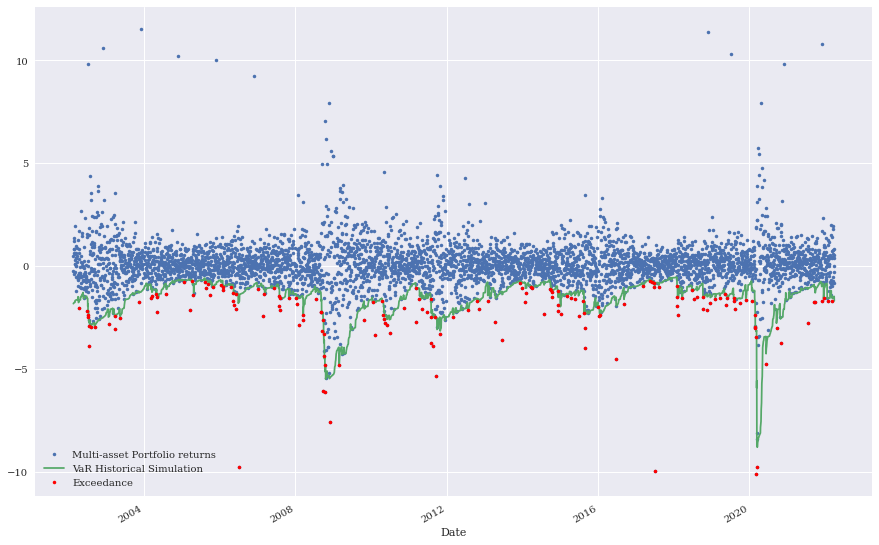

In [330]:
a.columns = ['Multi-asset Portfolio returns', 'VaR Historical Simulation', 'Exceedance']
plt.figure()
a.plot(style=['.','-', '.r'], figsize=(15, 10)); 


Plot VaR Cornish fisher

In [328]:
z = data[['Multiasset_returns','VaR_Cornish_Fisher']]
z['Exceedance']=''

for i in range (len(data)):
    if z['Multiasset_returns'].iloc[i]>z['VaR_Cornish_Fisher'].iloc[i]:
        z['Exceedance'].iloc[i]=np.nan
    else:
        z['Exceedance'].iloc[i]= z['Multiasset_returns'].iloc[i]

<Figure size 432x288 with 0 Axes>

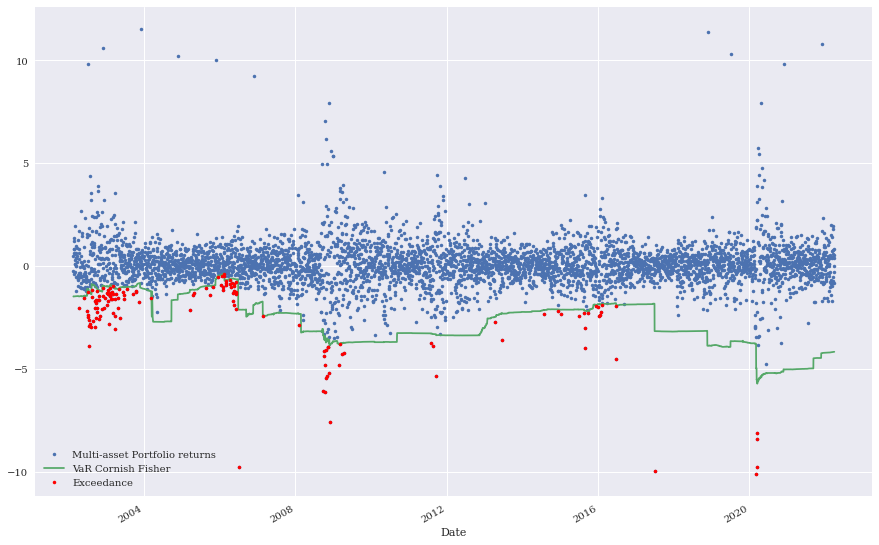

In [329]:
z.columns = ['Multi-asset Portfolio returns', 'VaR Cornish Fisher', 'Exceedance']
plt.figure()

z.plot(style=['.','-', '.r'], figsize=(15, 10)); 

Plot VaR Extreme Value Theory

In [377]:
y = data[['Multiasset_returns','VaR_EVT']]
y['Exceedance']=''

for i in range (len(data)):
    if y['Multiasset_returns'].iloc[i]>y['VaR_EVT'].iloc[i]:
        y['Exceedance'].iloc[i]=np.nan
    else:
        y['Exceedance'].iloc[i]= y['Multiasset_returns'].iloc[i]

<Figure size 432x288 with 0 Axes>

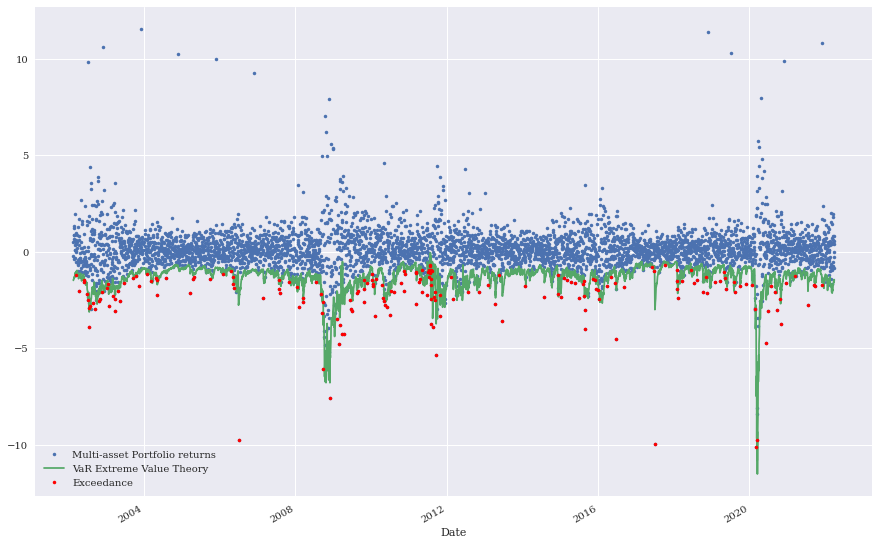

In [378]:
y.columns = ['Multi-asset Portfolio returns', 'VaR Extreme Value Theory', 'Exceedance']
plt.figure()

y.plot(style=['.','-', '.r'], figsize=(15, 10)); 


Plot VaR copula GARCH

<AxesSubplot:xlabel='Date'>

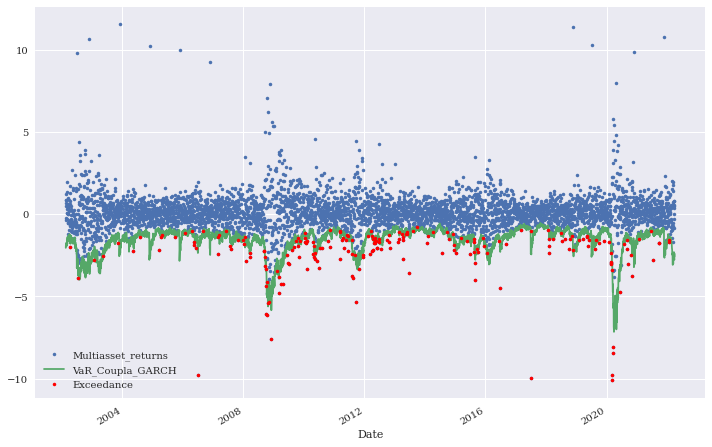

In [254]:
x = data[['Multiasset_returns','VaR_Coupla_GARCH']]
x['Exceedance']=''

for i in range (len(data)):
    if x['Multiasset_returns'].iloc[i]>x['VaR_Coupla_GARCH'].iloc[i]:
        x['Exceedance'].iloc[i]=np.nan
    else:
        x['Exceedance'].iloc[i]= x['Multiasset_returns'].iloc[i]

<Figure size 432x288 with 0 Axes>

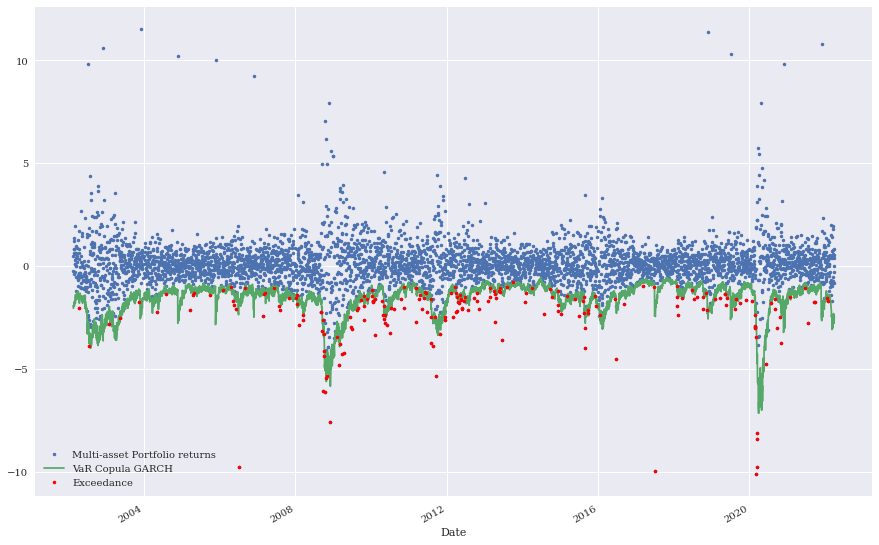

In [286]:
x.columns = ['Multi-asset Portfolio returns', 'VaR Copula GARCH', 'Exceedance']
plt.figure()

x.plot(style=['.','-', '.r'], figsize=(15, 10)); 



# DPPI STRATEGY

In [174]:
df_DPPI = pd.read_excel(r'C:\Users\samuv\OneDrive\Desktop\Tesi\Shorter window 500\Import For DPPI.xlsx', index_col=0, parse_dates=True)

In [175]:
df_DPPI['Rebalance_Date'] = ''

for i in range(0,len(df_DPPI),7):
    df_DPPI['Rebalance_Date'].iloc[i] = True

In [176]:
df_DPPI['Adjust_Floor'] = ''

for i in range (len(df_DPPI)-1):
    if df_DPPI.reset_index()['Date'].dt.year.iloc[i+1] > df_DPPI.reset_index()['Date'].dt.year.iloc[i]:
        df_DPPI['Adjust_Floor'].iloc[i+1] = True
    else:
         df_DPPI['Adjust_Floor'].iloc[i+1] = ''

In [177]:
#Parameters for the DPPI
Investment_amount = 100
Floor = 85

In [178]:
df_DPPI["Floor"] = ""
df_DPPI['Floor'].iloc[0] = 85

#for i in range(1, len(df_CPPI)):
    #df_CPPI['Floor'].iloc[i] = df_CPPI['Floor'].iloc[i-1] * (1+ df_CPPI['10Y Features'].iloc[i])

In [179]:
#empty column with Investment Value Index for DPPI before rebalancing
df_DPPI["Value_I(DPPI)"] = ""
#set first value 
df_DPPI['Value_I(DPPI)'].iloc[0] = (Investment_amount-Floor) * df_DPPI['Multiple'].iloc[0]

#empty column with Investment Value Bond for DPPI before rebalancing
df_DPPI["Value_B(DPPI)"] = ""
#set first value 
df_DPPI['Value_B(DPPI)'].iloc[0] = Investment_amount - df_DPPI['Value_I(DPPI)'].iloc[0]

#empty column with Investment Value Index for DPPI after rebalancing
df_DPPI["Value_I(DPPI)_a"] = ""
#set first value 
df_DPPI['Value_I(DPPI)_a'].iloc[0] = (Investment_amount-Floor)*df_DPPI['Multiple'].iloc[0]

#empty column with Investment Value Bond for DPPI after rebalancing
df_DPPI["Value_B(DPPI)_a"] = ""
#set first value 
df_DPPI['Value_B(DPPI)_a'].iloc[0] = Investment_amount - df_DPPI['Value_I(DPPI)'].iloc[0]

#empty column with Portfolio Value after rebalancing
df_DPPI["Value_P(DPPI)"] = ""
#set first value 
df_DPPI['Value_P(DPPI)'].iloc[0] = df_DPPI['Value_B(DPPI)_a'].iloc[0] + df_DPPI['Value_I(DPPI)_a'].iloc[0]

In [180]:
#fill columns with values of bond and index after value change before rebalancing and columns of value of bond and index after rebalancing
for i in range(1, len(df_DPPI)):
    df_DPPI['Value_B(DPPI)'].iloc[i] = df_DPPI['Value_B(DPPI)_a'].iloc[i-1] * (1+ df_DPPI['10Y Features'].iloc[i])
    df_DPPI['Value_I(DPPI)'].iloc[i] = df_DPPI['Value_I(DPPI)_a'].iloc[i-1] * (1+ df_DPPI['Multiasset_returns'].iloc[i])
    df_DPPI['Value_P(DPPI)'].iloc[i] = df_DPPI['Value_B(DPPI)'].iloc[i] + df_DPPI['Value_I(DPPI)'].iloc[i]
    
    if df_DPPI['Adjust_Floor'].iloc[i] == True:
        df_DPPI['Floor'].iloc[i] = df_DPPI['Value_P(DPPI)'].iloc[i-1]*0.85
    if df_DPPI['Adjust_Floor'].iloc[i] == '':
        df_DPPI['Floor'].iloc[i] = df_DPPI['Floor'].iloc[i-1] * (1+ df_DPPI['10Y Features'].iloc[i])
            
    if (df_DPPI['Rebalance_Date'].iloc[i] == True or df_DPPI['Value_P(DPPI)'].iloc[i] < df_DPPI['Floor'].iloc[i]):
        df_DPPI['Value_I(DPPI)_a'].iloc[i] = 0.99*((df_DPPI['Value_P(DPPI)'].iloc[i] - df_DPPI['Floor'].iloc[i]) * df_DPPI['Multiple'].iloc[i])
        df_DPPI['Value_B(DPPI)_a'].iloc[i] =  df_DPPI['Value_P(DPPI)'].iloc[i] - df_DPPI['Value_I(DPPI)_a'].iloc[i]
        
    if(df_DPPI['Rebalance_Date'].iloc[i] == ''):
        df_DPPI['Value_B(DPPI)_a'].iloc[i] = df_DPPI['Value_B(DPPI)'].iloc[i]
        df_DPPI['Value_I(DPPI)_a'].iloc[i] = df_DPPI['Value_I(DPPI)'].iloc[i]

Text(0, 0.5, 'Portfolio Value in USD')

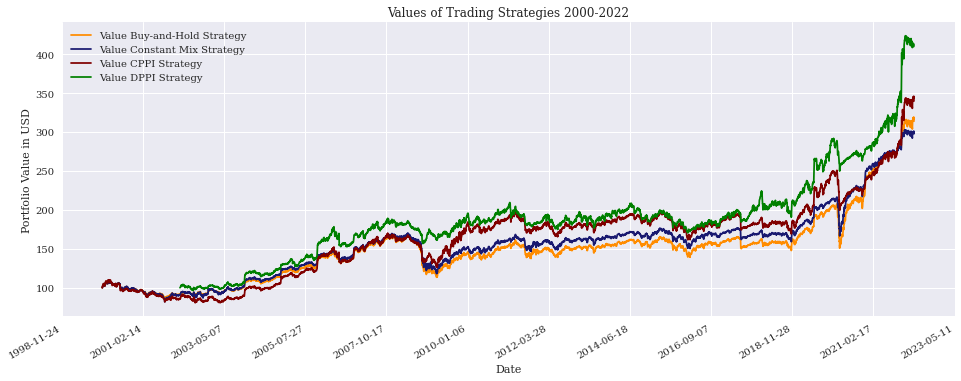

In [184]:
ax = plt.gca()

ax.title.set_text('Values of Trading Strategies 2000-2022')
df.plot(kind='line', y='Value_P(B&H)',label = 'Value Buy-and-Hold Strategy', color='darkorange', ax=ax, figsize=(16,6))
df_CM.plot(kind='line',y='Value_P(C-M)',label = 'Value Constant Mix Strategy', color ='midnightblue', ax=ax)
df_CPPI.plot(kind='line',y='Value_P(CPPI)',label = 'Value CPPI Strategy',color ='maroon', ax=ax)
df_DPPI.plot(kind='line',y='Value_P(DPPI)',label = 'Value DPPI Strategy',color ='green', ax=ax)
plt.gca().xaxis.set_major_locator(plt.LinearLocator(numticks=12))
ax.set_ylabel('Portfolio Value in USD')

# METRICS

In [193]:
strategies = pd.concat([df_DPPI['Value_P(DPPI)'], df['Value_P(B&H)'], df_CM['Value_P(C-M)'], df_CPPI['Value_P(CPPI)']], join="inner", ignore_index=False, axis=1)

In [214]:
strategies = strategies.pct_change().dropna()

In [225]:
def sharpe_ratio(return_series, N, rf):
    mean = return_series.mean() * N -rf
    sigma = return_series.std() * np.sqrt(N)
    return mean / sigma

N = 255 #255 trading days in a year
rf =0.01 #1% risk free rate
sharpes = df.apply(sharpe_ratio, args=(N,rf,),axis=0)

In [241]:
sharpes = sharpe_ratio(strategies, N, rf)

In [228]:
def sortino_ratio(series, N,rf):
    mean = series.mean() * N -rf
    std_neg = series[series<0].std()*np.sqrt(N)
    return mean/std_neg

In [243]:
sortinos = sortino_ratio(strategies, N, rf)

In [231]:
def max_drawdown(return_series):
    comp_ret = (return_series+1).cumprod()
    peak = comp_ret.expanding(min_periods=1).max()
    dd = (comp_ret/peak)-1
    return dd.min()

In [244]:
max_drawdowns = max_drawdown(strategies)

In [245]:
calmars = strategies.mean()*255/abs(max_drawdowns)

In [249]:
btstats = pd.DataFrame()

btstats['Sharpe Ratio'] = sharpes
btstats['Max Drawdown'] = max_drawdowns
btstats['Calmar Ratio'] = calmars
btstats['Sortino Ratio'] = sortinos

btstats

,Sharpe Ratio,Max Drawdown,Calmar Ratio,Sortino Ratio
Value_P(DPPI),0.601451,-0.185461,0.443988,0.908396
Value_P(B&H),0.552540,-0.324023,0.224848,0.725582
Value_P(C-M),0.554878,-0.306127,0.226564,0.743079
Value_P(CPPI),0.588244,-0.256607,0.317322,0.841263
